In [1]:
'''
Topic: EIF

Ref: 
https://github.com/sahandha/eif/blob/master/eif.py
https://github.com/sahandha/eif

'''

'\nTopic: EIF\n\nRef: \nhttps://github.com/sahandha/eif/blob/master/eif.py\nhttps://github.com/sahandha/eif\n\n'

In [2]:
""" Extended Isolation forest functions
This is the implementation of the Extended Isolation Forest anomaly detection algorithm. This extension, improves the consistency and reliability of the anomaly score produced by standard Isolation Forest represented by Liu et al.
Our method allows for the slicing of the data to be done using hyperplanes with random slopes which results in improved score maps. The consistency and reliability of the algorithm is much improved using this extension.
"""

__author__ = 'Matias Carrasco Kind & Sahand Hariri'
import numpy as np
import random as rn
import os
import warnings
from version import __version__


def c_factor(n) :
    """
    Average path length of unsuccesful search in a binary search tree given n points
    
    Parameters
    ----------
    n : int
        Number of data points for the BST.
    Returns
    -------
    float
        Average path length of unsuccesful search in a BST
        
    """
    return 2.0*(np.log(n-1)+0.5772156649) - (2.0*(n-1.)/(n*1.0))


class iForest(object):
    """
    Creates an iForest object. This object holds the data as well as the trained trees (iTree objects).
    Attributes
    ----------
    X : list
        Data used for training. It is a list of list of floats.
    nobjs: int
        Size of the dataset.
    sample: int
        Size of the sample to be used for tree creation.
    Trees: list
        A list of tree objects.
    limit: int
        Maximum depth a tree can have.
    exlevel: int
        Exention level to be used in the creating splitting critera.
    c: float
        Multiplicative factor used in computing the anomaly scores.
    Methods
    -------
    CheckExtensionLevel()
        Chaeck the validity of extension level provided by user based on the data
    compute_paths(X_in)
        Computes the anomaly score for data X_in
    """
    def __init__(self, X, ntrees,  sample_size, limit=None, ExtensionLevel=0,OutRatio=0.0):
        """
        iForest(X, ntrees,  sample_size, limit=None, ExtensionLevel=0)
        Initialize a forest by passing in training data, number of trees to be used and the subsample size.
        Parameters
        ----------
        X : list of list of floats
            Training data. List of [x1,x2,...,xn] coordinate points.
        ntrees : int
            Number of trees to be used.
        sample_size : int
            The size of the subsample to be used in creation of each tree. Must be smaller than |X|
        limit : int
            The maximum allowed tree depth. This is by default set to average length of unsucessful search in a binary tree.
        ExtensionLevel : int
            Specifies degree of freedom in choosing the hyperplanes for dividing up data. Must be smaller than the dimension n of the dataset.
        OutRatio : float
            The ratio of outliers in the training data. Should be between 0.0 and 0.5 
        """

        self.ntrees = ntrees
        self.X = X
        self.nobjs = len(X)
        self.sample = sample_size
        self.Trees = []
        self.limit = limit
        self.exlevel = ExtensionLevel
        self.CheckExtensionLevel()                                              # Extension Level check. See def for explanation.
        if limit is None:
            self.limit = int(np.ceil(np.log2(self.sample)))                     # Set limit to the default as specified by the paper (average depth of unsuccesful search through a binary tree).
        self.c = c_factor(self.sample)
        for i in range(self.ntrees):                                            # This loop builds an ensemble of iTrees (the forest).
            ix = rn.sample(range(self.nobjs), self.sample)
            X_p = X[ix]
            self.Trees.append(iTree(X_p, 0, self.limit, exlevel=self.exlevel))
        self.OutRatio = OutRatio
        
    def CheckExtensionLevel(self):
        """
        This function makes sure the extension level provided by the user does not exceed the dimension of the data. An exception will be raised in the case of a violation.
        """
        dim = self.X.shape[1]
        if self.exlevel < 0:
            raise Exception("Extension level has to be an integer between 0 and "+ str(dim-1)+".")
        if self.exlevel > dim-1:
            raise Exception("Your data has "+ str(dim) + " dimensions. Extension level can't be higher than " + str(dim-1) + ".")

    def outlier_pred(self, X_in =None):
        """
        outlier_pred(X_in= None)
        Predict outlier as '1' and nomal data as '0'
        Parameter
        ----------
        X_in : list of list of floats
                Data to be scored. iForest.Trees are used for computing the depth reached in each tree by each data point.
        Returns
        -------
        float
            Simulate the prediction label of '0' as normal data and '1' as outliers
        """
        if X_in is None:
            X_in = self.X                                                     # X_in = dataset X
        OutLabel = np.zeros(X_in.shape[0])
        OutLabel[self.outlier_index(X_in)] = 1     # create the array with '0' for normal data and '1' for outliers 
        return OutLabel   
    
    def outlier_index(self, X_in =None):
        """
        outlier_index(X_in= None)
        Resutrn the index of data points that are outliers 
        Parameter
        ----------
        X_in : list of list of floats
                Data to be scored. iForest.Trees are used for computing the depth reached in each tree by each data point.
        Returns
        -------
        int
            Indeces of outliers
        """
        if X_in is None:
            X_in = self.X                                                       # X_in = dataset X
        S = self.compute_paths(X_in)                                                 # anomaly score
        Ssort = np.ss0=np.argsort(S)                                            # index of the ordered score (low to high) 
        OutIndex = Ssort[-int(np.ceil(self.OutRatio * self.X.shape[0])):]       # the highest S score's indeces
        return OutIndex
            
    def compute_paths(self, X_in = None):
        """
        compute_paths(X_in = None)
        Compute anomaly scores for all data points in a dataset X_in
        Parameters
        ----------
        X_in : list of list of floats
                Data to be scored. iForest.Trees are used for computing the depth reached in each tree by each data point.
        Returns
        -------
        float
            Anomaly score for a given data point.
        """
        if X_in is None:
            X_in = self.X
        S = np.zeros(len(X_in))
        for i in  range(len(X_in)):
            h_temp = 0
            for j in range(self.ntrees):
                h_temp += PathFactor(X_in[i],self.Trees[j]).path*1.0            # Compute path length for each point
            Eh = h_temp/self.ntrees                                             # Average of path length travelled by the point in all trees.
            S[i] = 2.0**(-Eh/self.c)                                            # Anomaly Score
        return S

class Node(object):
    """
    A single node from each tree (each iTree object). Nodes containe information on hyperplanes used for data division, date to be passed to left and right nodes, whether they are external or internal nodes.
    Attributes
    ----------
    e: int
        Depth of the tree to which the node belongs.
    size: int
        Size of the dataset present at the node.
    X: list
        Data at the node.
    n: list
        Normal vector used to build the hyperplane that splits the data in the node.
    p: list
        Intercept point through which the hyperplane passes.
    lef: Node object
        Left child node.
    right: Node object
        Right child node.
    ntype: str
        The type of the node: 'exNode', 'inNode'.
    """
    def __init__(self, X, n, p, e, left, right, node_type = '' ):
        """
        Node(X, n, p, e, left, right, node_type = '' )
        Create a node in a given tree (iTree objectg)
        Parameters
        ----------
        X : list of list of floats
            Training data available to each node. List of [x1,x2,...,xn] coordinate points.
        n : list of floats
            Normal vector for the hyperplane used for splitting data.
        p : list of floats
            Intercept point for the hyperplane used for splitting data.
        left : Node object
            Left child node.
        right : Node object
            Right child node.
        node_type : str
            Specifies if the node is external or internal. Takes two values: 'exNode', 'inNode'.
        """
        self.e = e
        self.size = len(X)
        self.X = X # to be removed
        self.n = n
        self.p = p
        self.left = left
        self.right = right
        self.ntype = node_type

class iTree(object):

    """
    A single tree in the forest that is build using a unique subsample.
    Attributes
    ----------
    exlevel: int
        Extension level used in the splitting criteria.
    e: int
        Depth of tree
    X: list
        Data present at the root node of this tree.
    size: int
        Size of the dataset.
    dim: int
        Dimension of the dataset.
    Q: list
        List of ordered integers smaller than dim.
    l: int
        Maxium depth a tree can reach before its creation is terminated.
    n: list
        Normal vector at the root of this tree, which is used in creating hyperplanes for splitting critera
    p: list
        Intercept point at the root of this tree through which the splitting hyperplane passes.
    exnodes: int
        The number of external nodes this tree has.
    root: Node object
        At each node create a new tree.
    Methods
    -------
    make_tree(X, e, l)
        Builds the tree recursively from a given node. Returns a Node object.
    """

    def __init__(self,X,e,l, exlevel=0):
        """
        iTree(X, e, l, exlevel=0)
        Create a tree
        Parameters
        ----------
        X : list of list of floats
            Subsample of training data. |X| = iForest.sample_size. List of [x1,x2,...,xn] coordinate points
        e : int
            Depth of the tree as it is being traversed down. e <= l.
        l : int
            The maximum depth the tree can reach before its creation is terminated.
        exlevel : int
            Specifies degree of freedom in choosing the hyperplanes for dividing up data. Must be smaller than the dimension n of the dataset.
        """
        self.exlevel = exlevel
        self.e = e
        self.X = X                                                              #save data for now. Not really necessary.
        self.size = len(X)
        self.dim = self.X.shape[1]
        self.Q = np.arange(np.shape(X)[1], dtype='int')                         # n dimensions
        self.l = l
        self.p = None                                                           # Intercept for the hyperplane for splitting data at a given node.
        self.n = None                                                           # Normal vector for the hyperplane for splitting data at a given node.
        self.exnodes = 0
        self.root = self.make_tree(X,e,l)                                       # At each node create a new tree, starting with root node.

    def make_tree(self,X,e,l):
        """
        make_tree(X,e,l)
        Builds the tree recursively from a given node. Returns a Node object.
        Parameters
        ----------
        X: list of list of floats
            Subsample of training data. |X| = iForest.sample_size. List of [x1,x2,...,xn] coordinate point.
        e : int
            Depth of the tree as it is being traversed down. Integer. e <= l.
        l : int
            The maximum depth the tree can reach before its creation is terminated. Integer.
        Returns
        -------
        Node object
        """
        self.e = e
        if e >= l or len(X) <= 1:                                               # A point is isolated in traning data, or the depth limit has been reached.
            left = None
            right = None
            self.exnodes += 1
            return Node(X, self.n, self.p, e, left, right, node_type = 'exNode')
        else:                                                                   # Building the tree continues. All these nodes are internal.
            mins = X.min(axis=0)
            maxs = X.max(axis=0)
            idxs = np.random.choice(range(self.dim), self.dim-self.exlevel-1, replace=False)  # Pick the indices for which the normal vector elements should be set to zero acccording to the extension level.
            self.n = np.random.normal(0,1,self.dim)                             # A random normal vector picked form a uniform n-sphere. Note that in order to pick uniformly from n-sphere, we need to pick a random normal for each component of this vector.
            self.n[idxs] = 0
            self.p = np.random.uniform(mins,maxs)                               # Picking a random intercept point for the hyperplane splitting data.
            w = (X-self.p).dot(self.n) < 0                                      # Criteria that determines if a data point should go to the left or right child node.
            return Node(X, self.n, self.p, e,\
            left=self.make_tree(X[w],e+1,l),\
            right=self.make_tree(X[~w],e+1,l),\
            node_type = 'inNode' )

class PathFactor(object):
    """
    Given a single tree (iTree objext) and a data point x = [x1,x2,...,xn], compute the legth of the path traversed by the point on the tree when it reaches an external node.
    Attributes
    ----------
    path_list: list
        A list of strings 'L' or 'R' which traces the path a data point travels down a tree.
    x: list
        A single data point, which is represented as a list of floats.
    e: int
        The depth of a given node in the tree.
    Methods
    -------
    find_path(T)
        Given a tree, it finds the path a single data points takes.
    """
    def __init__(self,x,itree):
        """
        PathFactor(x, itree)
        Given a single tree (iTree objext) and a data point x = [x1,x2,...,xn], compute the legth of the path traversed by the point on the tree when it reaches an external node.
        Parameters
        ----------
        x : list of floats
            A data point x = [x1, x2, ..., xn].
        itree : iTree object
            A single tree.
        """
        self.path_list=[]
        self.x = x
        self.e = 0
        self.path  = self.find_path(itree.root)

    def find_path(self,T):
        """
        find_path(T)
        Given a tree, find the path for a single data point based on the splitting criteria stored at each node.
        Parameters
        ----------
        T : iTree object
        Returns
        -------
        int
            The depth reached by the data point.
        """
        if T.ntype == 'exNode':
            if T.size <= 1: return self.e
            else:
                self.e = self.e + c_factor(T.size)
                return self.e
        else:
            p = T.p                                                             # Intercept for the hyperplane for splitting data at a given node.
            n = T.n                                                             # Normal vector for the hyperplane for splitting data at a given node.

            self.e += 1

            if (self.x-p).dot(n) < 0:
                self.path_list.append('L')
                return self.find_path(T.left)
            else:
                self.path_list.append('R')
                return self.find_path(T.right)

def all_branches(node, current=[], branches = None):
    """
    Utility function used in generating a graph visualization. It returns all the branches of a given tree so they can be visualized.
    Parameters
    ----------
    node: Node object
    Returns
    -------
    list
        list of branches that were reached.
    """
    current = current[:node.e]
    if branches is None: branches = []
    if node.ntype == 'inNode':
        current.append('L')
        all_branches(node.left, current=current, branches=branches)
        current = current[:-1]
        current.append('R')
        all_branches(node.right, current=current, branches=branches)
    else:
        branches.append(current)
    return branches

# EXP1, test code

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
import random as rn
#import eif as iso
import seaborn as sb
sb.set_style(style="whitegrid")
sb.set_color_codes()
import scipy.ndimage
from scipy.interpolate import griddata
import numpy.ma as ma
from numpy.random import uniform, seed

In [4]:
mean1 = [10, 0]
cov1 = [[1, 0], [0, 1]]  

mean2 = [0, 10]
cov2 = [[1, 0], [0, 1]]

Nobjs = 500          # Size of dataset.
np.random.seed(1)    # Add this for repeatablilty of the experiment. 

x1, y1 = np.random.multivariate_normal(mean1, cov1, int(Nobjs/2)).T
x2, y2 = np.random.multivariate_normal(mean2, cov2, int(Nobjs/2)).T

# join the two clusters so as to make one dataset. 
x = np.concatenate((x1,x2))
y = np.concatenate((y1,y2))
X=np.array([x,y]).T

In [5]:
F0  = iForest(X,ntrees=100, sample_size=256, ExtensionLevel=0,OutRatio=0.05)
F1  = iForest(X,ntrees=100, sample_size=256, ExtensionLevel=1,OutRatio=0.05)

indices0new = F0.outlier_index(X_in=X)
indices1new = F1.outlier_index(X_in=X)

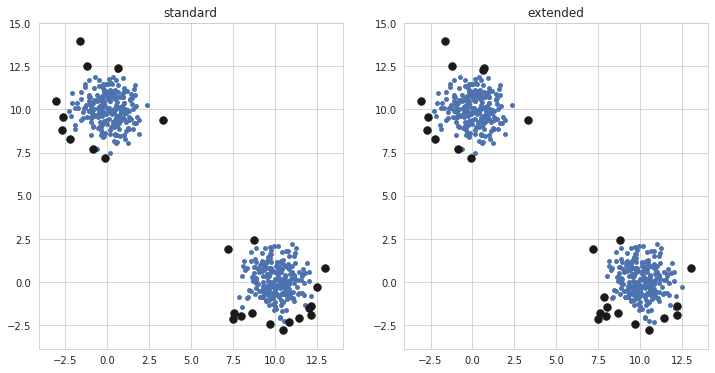

In [8]:
f = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(x,y,s=15,c='b',edgecolor='b')
#plt.scatter(x[ss0[-10:]],y[ss0[-10:]],s=55,c='k')
plt.scatter(x[indices0new],y[indices0new],s=55,c='k') 
plt.title('standard')

plt.subplot(1,2,2)
plt.scatter(x,y,s=15,c='b',edgecolor='b')
plt.scatter(x[indices1new],y[indices1new],s=55,c='k')
plt.title('extended')
plt.show()